# Do not run this part. A dedicated section to test the evaluation data is at the end of the notebook.

In [ ]:
import keras
keras.__version__

from PIL import Image
from google.colab import drive
from keras import layers
from keras import models
import time
from keras import optimizers
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import os
import PIL
from keras.applications import VGG16
from keras.layers import Conv2D,Activation,GlobalMaxPooling2D, Dense, Dropout
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import classification_report
from itertools import compress
import random

### **Mount Drive**

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Load datasets

In [ ]:
main_path = "/content/drive/My Drive/Challenge/Training"

In [ ]:
ALLOWED_EXTENSIONS = ['jpg', 'png', 'jpeg']

def get_data (main_path):
  label_names = os.listdir(main_path)
  dataset_path = []
  labels = []
  for label in label_names:
    full_path = os.path.join(main_path, label)
    files = os.listdir(full_path)
    for file_ in files:
      ext = file_.split('.')[-1]
      if ext in ALLOWED_EXTENSIONS:
        path = os.path.join(full_path,file_)
        dataset_path.append(path)
        labels.append(label)
        
  return dataset_path, labels, label_names

## Get data

In [ ]:
dataset_path, labels, label_names = get_data(main_path)

In [ ]:
print(f"Data: {len(dataset_path)}\nLabels: {len(labels)}\nClasses: {label_names}")

Data: 607
Labels: 607
Classes: ['Leffe', 'Modelo', 'Stella', 'Heineken', 'Corona']


# DATA VISUALIZATION AND EXPLORATION

In [ ]:
# Get index of specific class
def find_indices(list_to_check, item_to_find):
  indices = []
  for idx, value in enumerate(list_to_check):
    if value == item_to_find:
      indices.append(idx)
  return indices

### Sample of each class

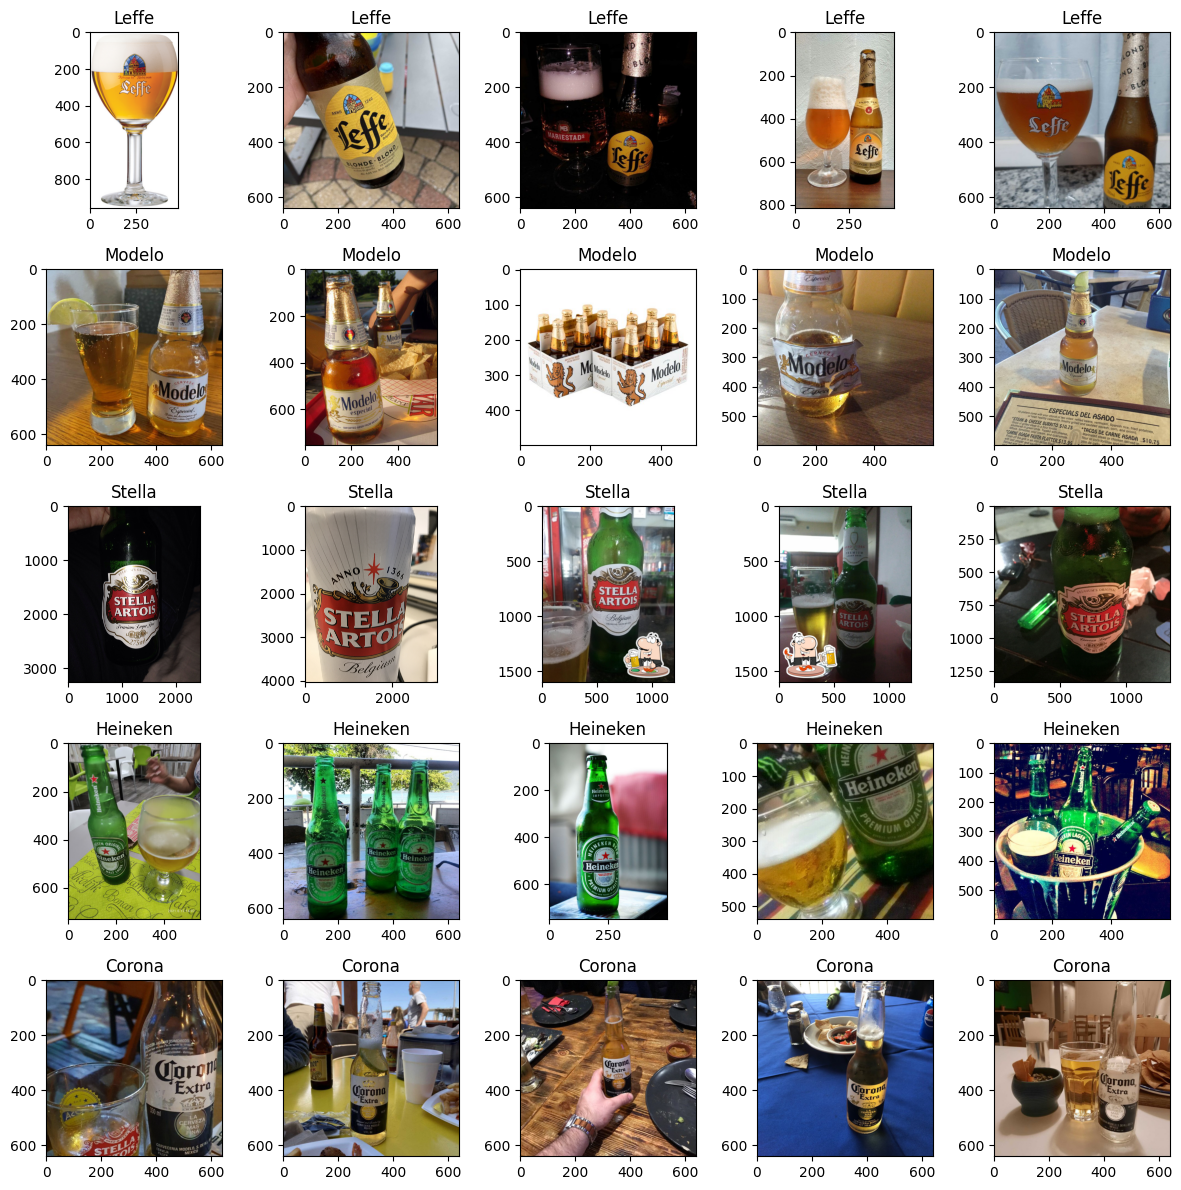

In [ ]:
fig, axs = plt.subplots(5,5, figsize=(12,12))
count = 0

for i in range(5):
  label_index = find_indices(labels,label_names[i])
  img_index = label_index[:5]
  for j in range(5):
    # get full img path
    img = os.path.join(main_path,label_names[i], dataset_path[img_index[j]])
    img = PIL.Image.open(img)
    axs[count][j].imshow(img)
    axs[count][j].set_title(label_names[i], fontsize=12)

  count += 1

fig.tight_layout()

### Images per class

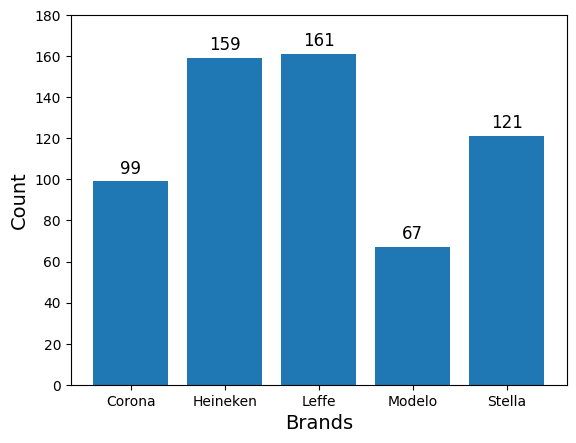

In [ ]:
unique, counts = np.unique(labels, return_counts=True)

fig, ax = plt.subplots()
bars = plt.bar(unique, counts)
for bar in bars:
   height = bar.get_height()
   plt.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), size=12,
   textcoords="offset points", ha='center', va='bottom')

plt.ylim([0,180])
plt.xlabel("Brands", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

# Findings:
* Unbalanced Data
* Inconsistent data size


**First, the images will be resized to maintain their aspect ratio. Then, based on the newly resized images, the classes will be augmented using an ImageDataGenerator to balance the dataset.**

# Resize data

In [ ]:
def make_square(im, fill_color=(0, 0, 0)):
    x, y = im.size
    size = max(x, y)
    new_im = Image.new('RGB', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

### Save resized images

In [ ]:
# Generate resized images directory
resized_dir ="/content/drive/My Drive/Challenge/Resized_Training"

if os.path.isdir(resized_dir):
  print("Resized_Training images already saved")
else:
  os.mkdir(resized_dir)
  ctr = 0
  for i_path, i_label in zip(dataset_path,labels):
    img_name = os.path.join(resized_dir,i_label,i_path.split("/")[-1].split(".")[0]) + f"_{str(ctr)}.jpg"
    #print(img_name)
    img = Image.open(i_path)
    x,y = img.size
    if x != y: 
      img = make_square(img)
    img.convert("RGB").save(img_name)
    ctr += 1

Resized_Training images already saved


### Verify number of resized images

In [ ]:
print(resized_dir)
resized_dataset_path, resized_labels, _ = get_data(resized_dir)
print(f"Data: {len(resized_dataset_path)}\nLabels: {len(resized_labels)}\nClasses: {label_names}")

/content/drive/My Drive/Challenge/Resized_Training
Data: 607
Labels: 607
Classes: ['Leffe', 'Modelo', 'Stella', 'Heineken', 'Corona']


# Data Augmentation

In [ ]:
# Format data in a dataframe
resized_data_dict = {"paths": resized_dataset_path, "labels":resized_labels}
df = pd.DataFrame(resized_data_dict)
df.head(3)

paths labels
0  /content/drive/My Drive/Challenge/Resized_Trai...  Leffe
1  /content/drive/My Drive/Challenge/Resized_Trai...  Leffe
2  /content/drive/My Drive/Challenge/Resized_Trai...  Leffe

In [ ]:
aug_dir = "/content/drive/My Drive/Challenge/Augmented"

if os.path.isdir(aug_dir):
  print("augmented images already saved")
else:
  os.mkdir(aug_dir)

  for label in label_names:
    os.mkdir(os.path.join(aug_dir,label))

  # Augmented features
  augmented_datagen = ImageDataGenerator(
      rotation_range=20, 
      width_shift_range=.2,
      height_shift_range=.2, 
      zoom_range=.2,
      brightness_range=[0.8,1.2]
  )

  target = 200
  groups=df.groupby('labels') # group by class
  for label in df['labels'].unique():  # for every class 
      group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
      sample_count=len(group)   # determine how many samples there are in this class
      if sample_count< target: # if the class has less than target number of images
        aug_img_count=0
        delta=target-sample_count  # number of augmented images to create
        target_dir=os.path.join(aug_dir, label)  # define where to write the images 
        aug_gen=augmented_datagen.flow_from_dataframe(group,  x_col='paths', y_col=None, color_mode='rgb', class_mode=None, batch_size=1,
                                                      shuffle=False, save_to_dir=target_dir, save_prefix='aug-',save_format='jpg')
      while aug_img_count<delta:
        images=next(aug_gen)         
        aug_img_count += len(images) 

augmented images already saved


# Visualize Augmented Data

In [ ]:
aug_dataset_path, aug_labels, _ = get_data(aug_dir)

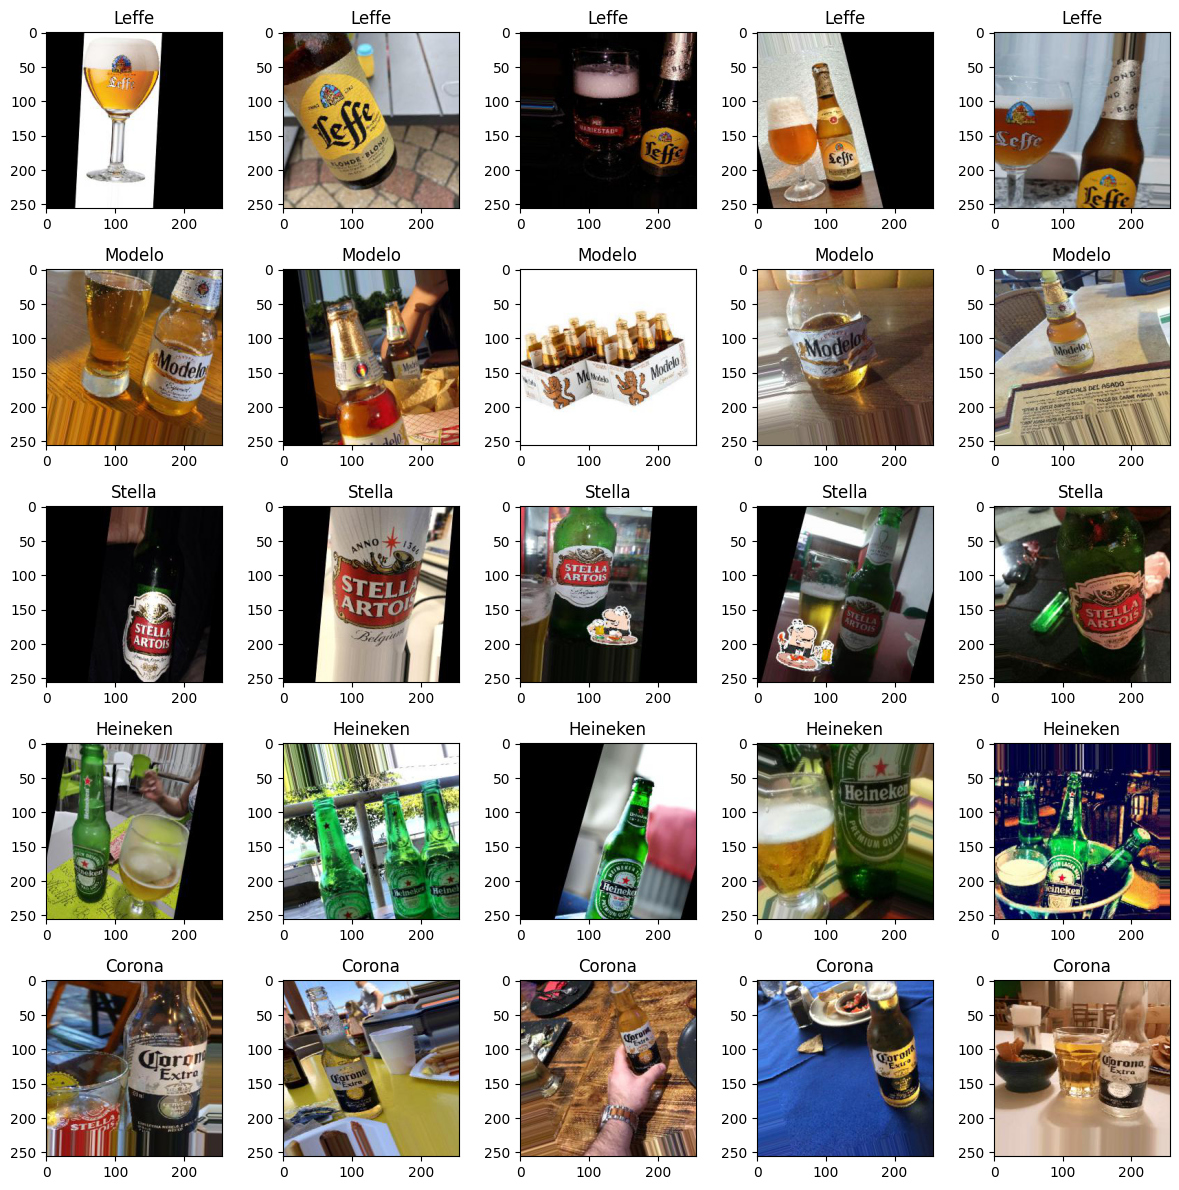

In [ ]:
fig, axs = plt.subplots(5,5, figsize=(12,12))
count = 0

for i in range(5):
  label_index = find_indices(aug_labels,label_names[i])
  img_index = label_index[:5]
  for j in range(5):
    # get full img path
    img = os.path.join(aug_dir,label_names[i], aug_dataset_path[img_index[j]])
    img = PIL.Image.open(img)
    axs[count][j].imshow(img)
    axs[count][j].set_title(label_names[i], fontsize=12)

  count += 1

fig.tight_layout()

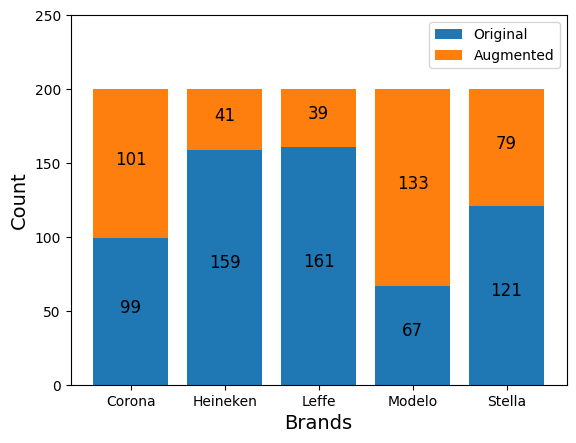

In [ ]:
final_dataset_labels = resized_labels + aug_labels
final_dataset_paths = resized_dataset_path + aug_dataset_path

unique, counts_1 = np.unique(resized_labels, return_counts=True)
unique, counts_2 = np.unique(aug_labels, return_counts=True)

fig, ax = plt.subplots()
bars_1 = plt.bar(unique, counts_1)
bars_2 = plt.bar(unique, counts_2, bottom=counts_1)

for bar_1, bar_2 in zip(bars_1, bars_2):
   height_1 = bar_1.get_height()
   height_2 = bar_2.get_height()

   plt.annotate(f'{height_1}', xy=(bar_1.get_x() + bar_1.get_width() / 2, height_1 /2), xytext=(0, 3), size=12,
   textcoords="offset points", ha='center', va='center')

   plt.annotate(f'{height_2}', xy=(bar_2.get_x() + bar_2.get_width() / 2, (height_1 + height_2 /2)), xytext=(0, 3), size=12,
   textcoords="offset points", ha='center', va='center')

plt.ylim([0,250])
plt.xlabel("Brands", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend(["Original", "Augmented"])
plt.show()

# Split into Training and Validation Set

In [ ]:
IMG_SIZE=250
scaled_images=[]
for path in final_dataset_paths:
  img = Image.open(path)
  img = img.resize((IMG_SIZE,IMG_SIZE))
  img = np.array(img)
  scaled_images.append(img / 255)

In [ ]:
# Get numerical labels
num_labels = []

for label in final_dataset_labels:
  if label == "Modelo":
    num_labels.append(0)
  elif label == "Corona":
    num_labels.append(1)
  elif label == "Leffe":
    num_labels.append(2)
  elif label == "Heineken":
    num_labels.append(3)
  else:
    num_labels.append(4)

In [ ]:
# Joing data path to track the testing images
aux_tuple = tuple(zip(final_dataset_paths, num_labels))
X_train, X_test, y_train_tuple, y_test_tuple = train_test_split(np.array(scaled_images), aux_tuple, test_size=0.1, random_state=42, stratify=num_labels, shuffle=True)

In [ ]:
# Separate tuple
train_paths = [i[0] for i in y_train_tuple]
test_paths = [i[0] for i in y_test_tuple]
y_train = [i[1] for i in y_train_tuple]
y_test = [i[1] for i in y_test_tuple]

In [ ]:
# Check Train data shape
X_train.shape

(900, 250, 250, 3)

# Loading and finetuning VGG16

In [ ]:
from keras.applications import VGG16
from keras.layers import Conv2D,Activation,GlobalMaxPooling2D, Dense
from keras.models import Model

input_shape = (IMG_SIZE, IMG_SIZE, 3)

# Load VGG 16
pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

# Mantain initial 15 layer frozen
for layer in pre_trained_model.layers[:15]:
  layer.trainable= False

for layer in pre_trained_model.layers[15:]:
  layer.trainable =True

last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output

# ADD layers

x = GlobalMaxPooling2D(name="global_max_pool")(last_output)

x = Dropout(0.5, name="dropout")(x)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu', name="dense_1")(x)
# Add a final sigmoidlayer for classification
out = layers.Dense(len(label_names), activation="softmax", name="softmax")(x)

model = Model(pre_trained_model.input, out)
model.compile(loss="",
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=["accuracy"])
model.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 250, 250, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 250, 250, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 125, 125, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 125, 125, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 125, 125, 128)     147584    
                                                              

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### Compile the model

In [ ]:
history = model.compile(
              loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4), 
              metrics=['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
tic = time.time()

y_encoded = []
for x in y_train:
  actions = np.zeros(5)
  actions[x] = 1.0
  y_encoded.append(actions)
y_encoded = np.stack(y_encoded)

tf.config.run_functions_eagerly(True)

history= model.fit(x = X_train, 
             y = y_encoded,
             validation_split = 0.20, 
             epochs = 6,
             batch_size=16,
             verbose=1)

print('seconds=', time.time()-tic)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/6
45/45 [==============================] - 41s 515ms/step - loss: 1.1957 - acc: 0.4944 - precision: 0.7211 - recall: 0.2944 - val_loss: 0.4978 - val_acc: 0.8722 - val_precision: 0.9630 - val_recall: 0.7222
Epoch 2/6
45/45 [==============================] - 19s 421ms/step - loss: 0.4583 - acc: 0.8361 - precision: 0.9181 - recall: 0.7625 - val_loss: 0.2909 - val_acc: 0.9167 - val_precision: 0.9581 - val_recall: 0.8889
Epoch 3/6
45/45 [==============================] - 19s 426ms/step - loss: 0.2105 - acc: 0.9264 - precision: 0.9474 - recall: 0.9000 - val_loss: 0.1863 - val_acc: 0.9500 - val_precision: 0.9545 - val_recall: 0.9333
Epoch 4/6
45/45 [==============================] - 20s 452ms/step - loss: 0.1312 - acc: 0.9583 - precision: 0.9661 - recall: 0.9514 - val_loss: 0.1584 - val_acc: 0.9389 - val_precision: 0.9595 - val_recall: 0.9222
Epoch 5/6
45/45 [==============================] - 21s 459ms/step - loss: 0.0691 - acc: 0.9764 - precision: 0.9845 - recall: 0.9694 - val_loss: 

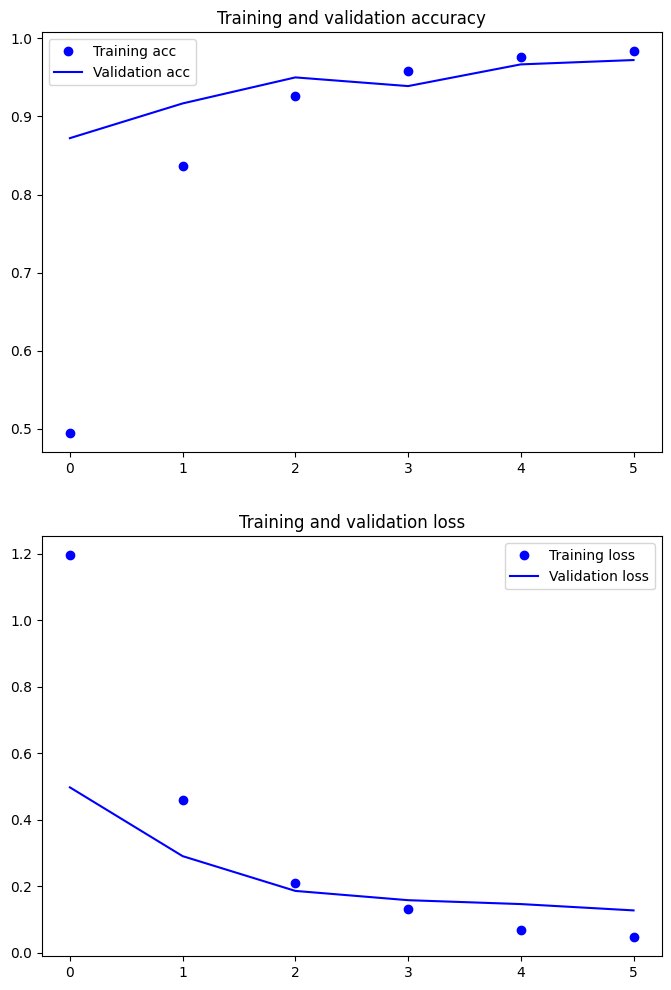

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(8,12))

plt.subplot(211)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()


plt.subplot(212)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Testing results

In [ ]:
test_predicted_labels = model.predict(X_test)
test_true_labels = np.array(y_test)
test_predicted_labels = np.argmax(test_predicted_labels,axis=1)
print("Accuracy: ", sum(test_true_labels == test_predicted_labels) / len(test_true_labels))


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


4/4 [==============================] - 1s 189ms/step
Accuracy:  0.99


In [ ]:
label_names_aux =["Modelo", "Corona", "Leffe", "Heineken", "Stella"]
type(label_names_aux)

list

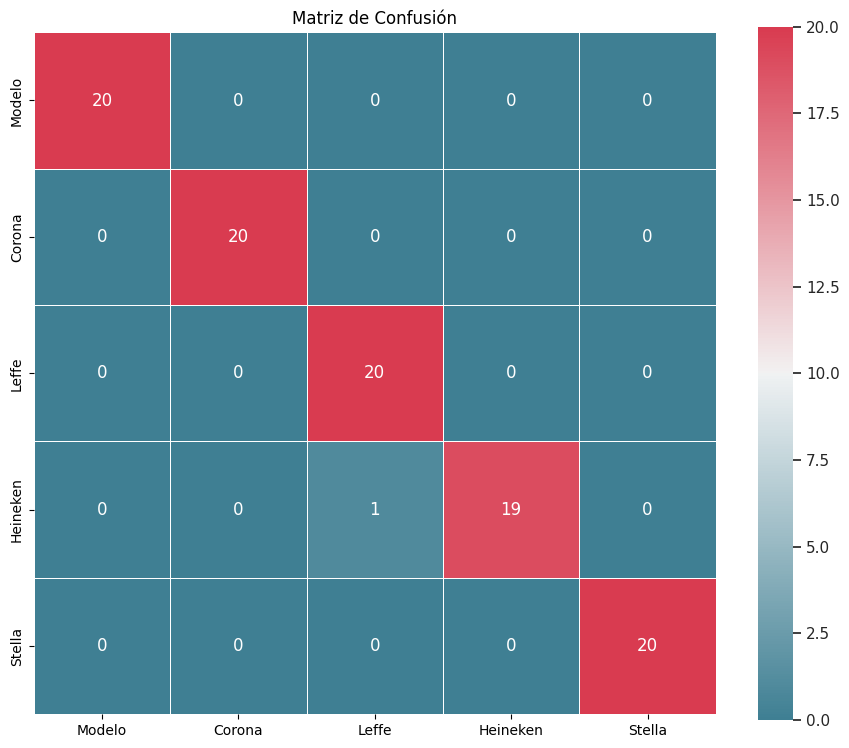

In [ ]:
#from sklearn.metrics import confusion_matrix, precision_score, recall_score 
C = confusion_matrix(test_true_labels, test_predicted_labels)

f, ax = plt.subplots(figsize=(11, 9))
sns.set()
cmap = sns.diverging_palette(220, 8, as_cmap=True)
ax = sns.heatmap(C, cmap=cmap, square=True,
                 annot=True, fmt='d', linewidths=.5)
ax.set_title('Matriz de Confusión')
ax.set_xticklabels(label_names_aux)
ax.set_yticklabels(label_names_aux)
plt.show()

In [ ]:
save_model_name ="/content/drive/My Drive/Challenge/Models/beer_brand_classifier.hdf5"
model.save(save_model_name)

# GRAD-CAM ANALYSIS

In [ ]:
# Code from: https://keras.io/examples/vision/grad_cam

def grad_cam(img):

  # Convert the image to array of type float32
  img = np.asarray(img, dtype = np.float32)

  # Reshape the image
  img = img.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
  img_scaled = img / 255

  # Name of the average pooling layer and dense final (you can see these names in the model summary)
  classification_layers = ["dense_1","softmax"]

  # Last convolutional layer in the model
  final_conv = model.get_layer("block5_pool")

  # Create a model with original model inputs and the last conv_layer as the output
  final_conv_model = keras.Model(model.inputs, final_conv.output)

  # Then we create the input for classification layer, which is the output of last conv layer
  classification_input = keras.Input(shape = final_conv.output.shape[1:])

  # We iterate through the classification layers, to get the final layer and then append 
  # the layer as the output layer to the classification model.
  temp = classification_input
  for layer in classification_layers:
      temp = model.get_layer(layer)(temp)
  classification_model = keras.Model(classification_input, temp)


  # We use gradient tape to monitor the 'final_conv_output' to retrive the gradients
  # corresponding to the predicted class
  with tf.GradientTape() as tape:
      # Pass the image through the base model and get the feature map 
      final_conv_output = final_conv_model(img_scaled)

      # Assign gradient tape to monitor the conv_output
      tape.watch(final_conv_output)
      
      # Pass the feature map through the classification model and use argmax to get the 
      # index of the predicted class and then use the index to get the value produced by final
      # layer for that class
      prediction = classification_model(final_conv_output)
      predicted_class = tf.argmax(prediction[0][0][0])
      predicted_class_value = prediction[:,:,:,predicted_class]
  
  # Get the gradient corresponding to the predicted class based on feature map.
  gradient = tape.gradient(predicted_class_value, final_conv_output)

  # Reduce the other dimensions, 
  gradient_channels = tf.reduce_mean(gradient, axis=(0, 1, 2))

  # We then convert the feature map produced by last conv layer
  final_conv_output = final_conv_output.numpy()[0]

  gradient_channels = gradient_channels.numpy()

  # We multiply the filters in the feature map produced by final conv layer by the 
  # filter values that are used to get the predicted class. By doing this we inrease the
  # value of areas that helped in making the prediction and lower the value of areas, that 
  # did not contribute towards the final prediction
  for i in range(gradient_channels.shape[-1]):
      final_conv_output[:, :, i] *= gradient_channels[i]

  # We take the mean accross the channels to get the feature map
  heatmap = np.mean(final_conv_output, axis=-1)

  # Normalizing the heat map between 0 and 1, to visualize it
  heatmap_normalized = np.maximum(heatmap, 0) / np.max(heatmap)

  # Rescaling and converting the type to int
  heatmap = np.uint8(255 * heatmap_normalized )

  # Create the colormap
  color_map = plt.cm.get_cmap('viridis')

  # get only the rb features from the heatmap
  color_map = color_map(np.arange(256))[:, :3]
  heatmap = color_map[heatmap]

  # convert the array to image, resize the image and then convert to array
  heatmap = keras.preprocessing.image.array_to_img(heatmap)
  heatmap = heatmap.resize((IMG_SIZE, IMG_SIZE))
  heatmap = np.asarray(heatmap, dtype = np.float32)

  # Add the heatmap on top of the original image
  final_img = heatmap * 1.0 + img[0]
  final_img = keras.preprocessing.image.array_to_img(final_img)

  return final_img, heatmap_normalized

## Separate right/wrong sets

In [ ]:
testing_labels = [label_names_aux[x] for x in test_true_labels]
prediction = [label_names_aux[x] for x in test_predicted_labels]

rigth_list = [testing_labels[i] == prediction[i] for i in range(len(prediction))]
right_idx = [i for i, x in enumerate(rigth_list) if x]
wrong_idx = [i for i, x in enumerate(rigth_list) if not x]
idx_list = [i for i, x in enumerate(rigth_list)]

In [ ]:
image = []
x_test = []

# Formatting
for i_path in test_paths:
    img= PIL.Image.open(i_path).convert("RGB")
    img = img.resize((IMG_SIZE,IMG_SIZE))
    image.append(img)

    img = np.asarray(img, dtype= np.float32)
    img = img / 255
    x_test.append(img)

## Visalize Right Predictions (GRAD-CAM)

83


<ipython-input-43-a1b4cf2e22d9>:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis')


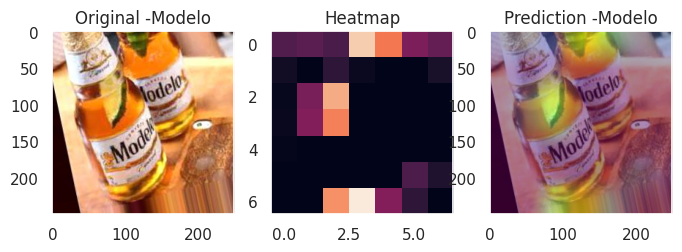

85


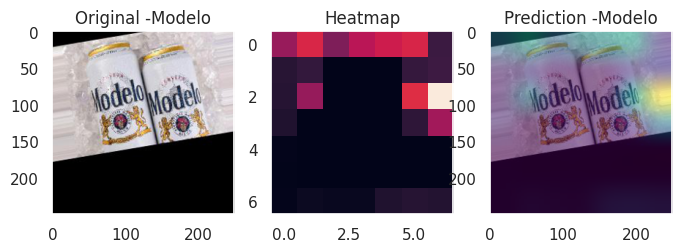

27


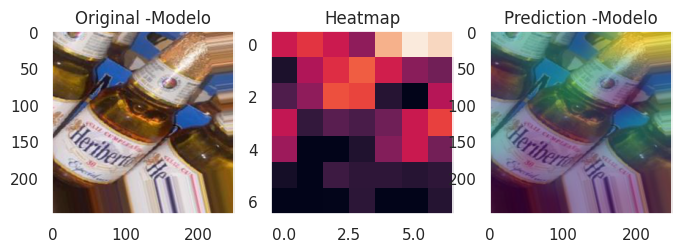

28


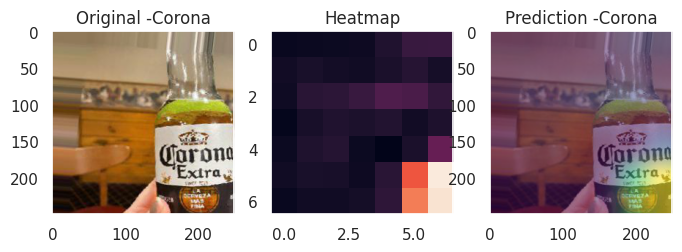

39


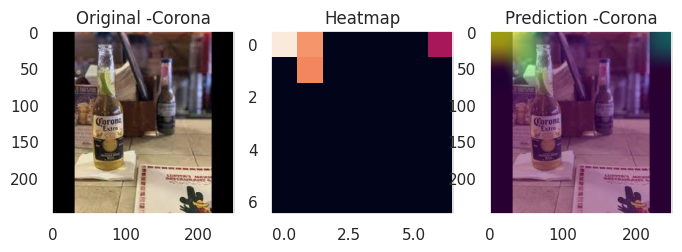

43


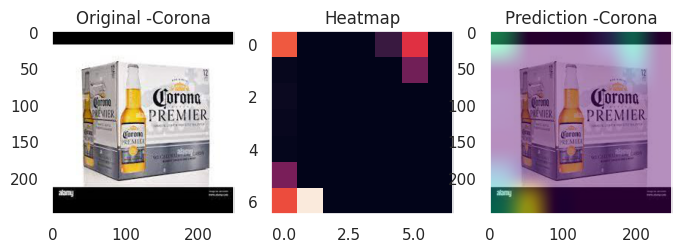

88


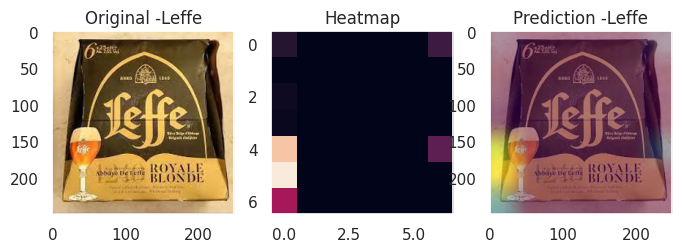

58


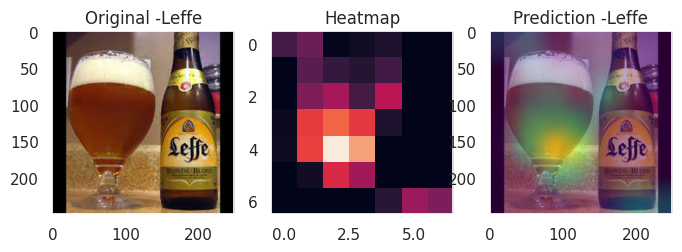

7


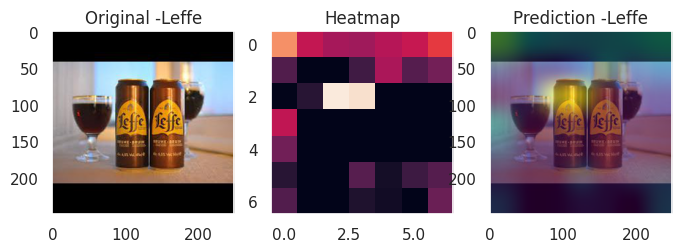

71


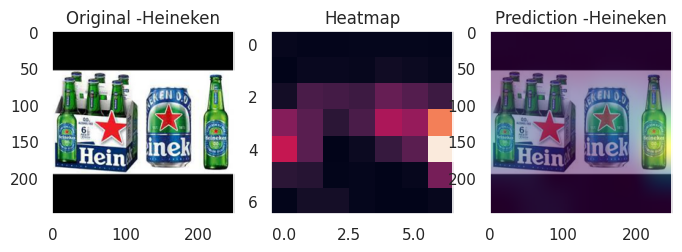

8


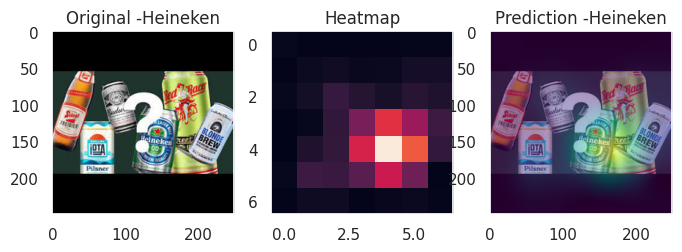

82


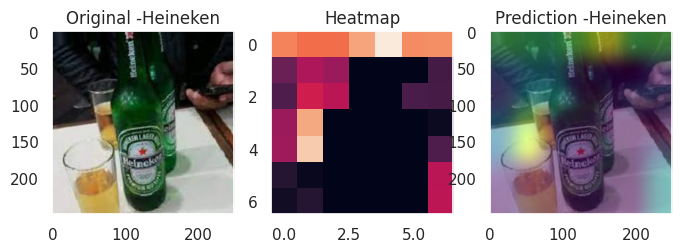

25


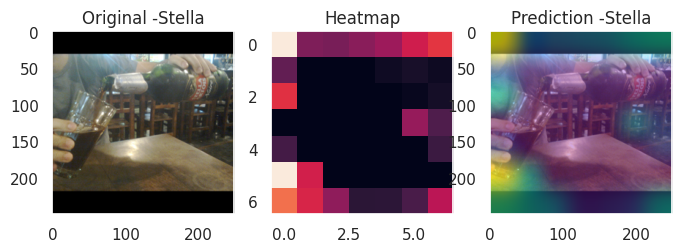

34


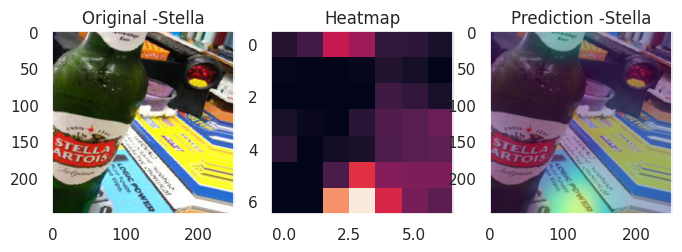

70


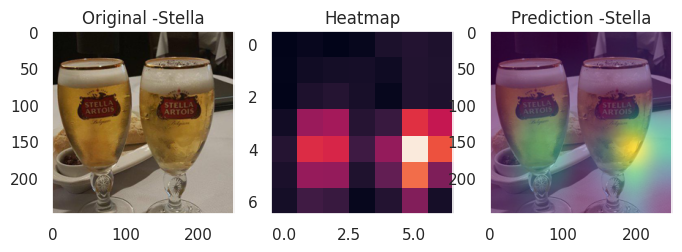

In [ ]:
#Visualize the images in the dataset

for idx in range(5):
  for x in range(3):
    try:
      i=random.choice(list(set(find_indices(testing_labels, label_names_aux[idx])).intersection(right_idx)))
    except:
      i=random.choice(list(compress(idx_list,rigth_list)))
    print(i)
    plt.figure(figsize = (8,8))
    plt.subplot(131)
    #i = random.randint(0, len(image))
    gradcam, heatmap = grad_cam(image[i])
    plt.title("Original -" + testing_labels[i])
    plt.imshow(image[i])
    plt.grid(False)

    plt.subplot(132)
    plt.title("Heatmap") 
    plt.imshow(heatmap)
    plt.grid(False)
    
    plt.subplot(133)
    plt.title("Prediction -" + prediction[i]) 
    plt.imshow(gradcam)  
    plt.grid(False)

    plt.show()

## Visalize Wrong Predictions (GRAD-CAM)

<ipython-input-31-a1b4cf2e22d9>:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis')


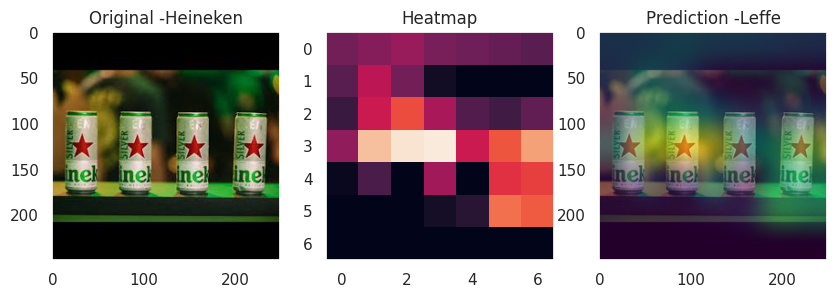

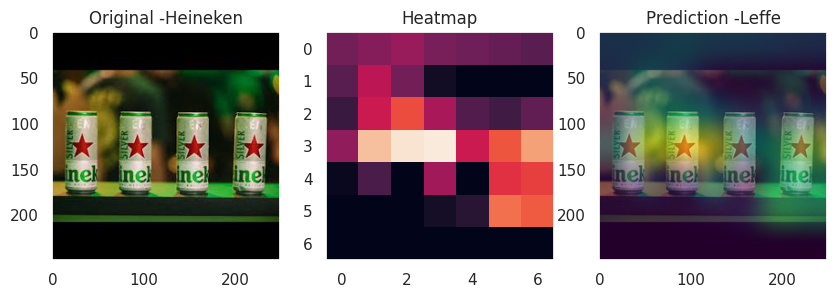

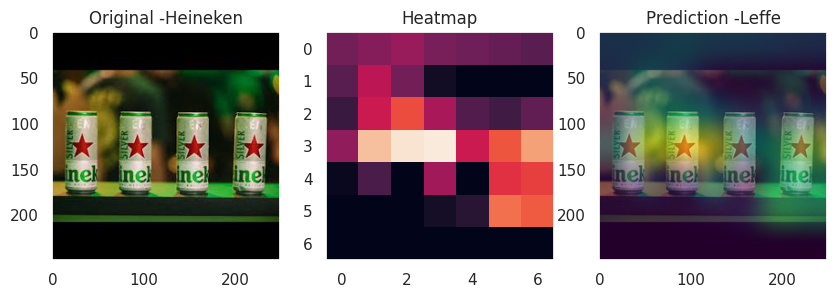

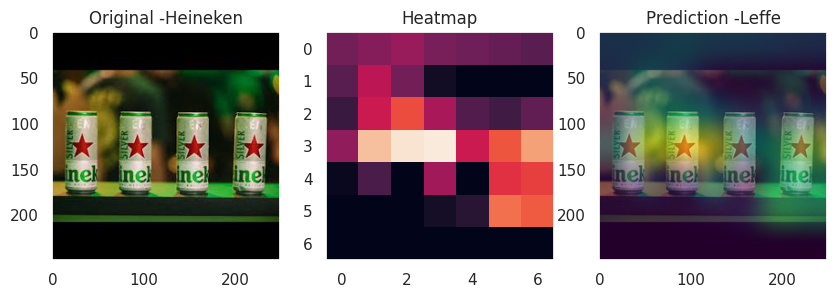

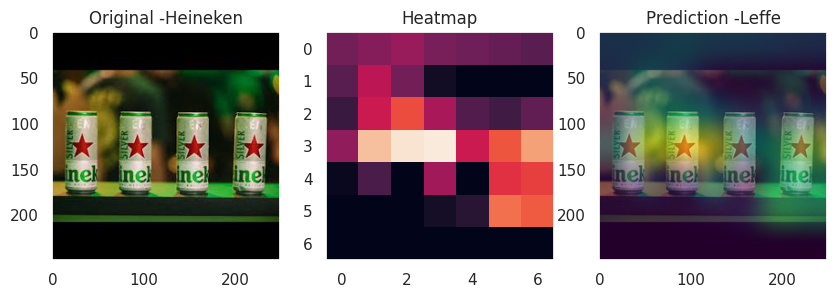

In [ ]:
#Visualize the images in the dataset
# from itertools import compress
# import random

for idx in range(5):
  try:
    i=random.choice(list(set(find_indices(testing_labels, label_names_aux[idx])).intersection(wrong_idx)))
  except:
    i=random.choice(list(compress(idx_list,list(~np.array(rigth_list)))))
  plt.figure(figsize = (10,10))
  plt.subplot(131)
  gradcam, heatmap = grad_cam(image[i])
  plt.title("Original -" + testing_labels[i])
  plt.imshow(image[i])
  plt.grid(False)

  plt.subplot(132)
  plt.title("Heatmap") 
  plt.imshow(heatmap)
  plt.grid(False)
  
  plt.subplot(133)
  plt.title("Prediction -" + prediction[i]) 
  plt.imshow(gradcam)  
  plt.grid(False)

  plt.show()


---


# FOR TESTING DIFFERENT DATASET

1. Insert model path
2. Insert test folder path
3. Accept google drive permissions


---



### ADD PATH OF THE MODEL AND TEST FOLDER

In [ ]:
#model_path = "/content/drive/My Drive/Challenge/Models/beer_brand_classifier.hdf5"
#test_path = "/content/drive/My Drive/Challenge/Testing"
IMG_SIZE=250
LABEL_NAMES =["Modelo", "Corona", "Leffe", "Heineken", "Stella"]

model_path = "INSERT_PATH_OF_THE_MODEL"
test_path = "INSTER_PATH_OF_THE_EVALUATION_FOLDER"

#### Imports

In [ ]:
import keras
keras.__version__

from PIL import Image
from google.colab import drive
from keras import layers
from keras import models
import time
from keras import optimizers
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import os
import PIL
from keras.applications import VGG16
from keras.layers import Conv2D,Activation,GlobalMaxPooling2D, Dense, Dropout
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import classification_report
from itertools import compress
import random

### MOUNT DRIVE

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


#### Functions

In [ ]:
def prepare_images(test_dataset):
  test_images = []
  images = []
  # Prepare images for testing
  for i_path in test_dataset:
    img = Image.open(i_path)
    x,y = img.size
    if x != y: 
      img = make_square(img)
    img = img.convert("RGB")
    img = img.resize((IMG_SIZE,IMG_SIZE))
    images.append(img)
    img = np.array(img)
    test_images.append(img / 255)
  return images, test_images

# Get numerical labels
def get_num_labels(test_labels):
  num_labels = []
  for label in test_labels:
    if label == "Modelo":
      num_labels.append(0)
    elif label == "Corona":
      num_labels.append(1)
    elif label == "Leffe":
      num_labels.append(2)
    elif label == "Heineken":
      num_labels.append(3)
    else:
      num_labels.append(4)
  return num_labels

# Get index of specific class
def find_indices(list_to_check, item_to_find):
  indices = []
  for idx, value in enumerate(list_to_check):
    if value == item_to_find:
      indices.append(idx)
  return indices

ALLOWED_EXTENSIONS = ['jpg', 'png', 'jpeg']

def get_data (main_path):
  label_names = os.listdir(main_path)
  dataset_path = []
  labels = []
  for label in label_names:
    full_path = os.path.join(main_path, label)
    files = os.listdir(full_path)
    for file_ in files:
      ext = file_.split('.')[-1]
      if ext in ALLOWED_EXTENSIONS:
        path = os.path.join(full_path,file_)
        dataset_path.append(path)
        labels.append(label)
        
  return dataset_path, labels, label_names

def make_square(im, fill_color=(0, 0, 0)):
    x, y = im.size
    size = max(x, y)
    new_im = Image.new('RGB', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

def get_encoded_label(y_train):
  y_encoded = []
  for x in y_train:
    actions = np.zeros(5)
    actions[x] = 1.0
    y_encoded.append(actions)
  y_encoded = np.stack(y_encoded)
  return y_encoded

In [ ]:
# Load Model
model = keras.models.load_model(model_path)

# Get path and labels from test folder
test_dataset_path_2, test_labels_2, _ = get_data(test_path)


# Get images for testing and for GRAD-CAM results
images, test_images = prepare_images(test_dataset_path_2)

# Get numerical labels
num_labels = get_num_labels(test_labels_2)

# Get encoded labels
encoded_labels = get_encoded_label(num_labels)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


### Test model

In [ ]:
test_predicted_labels = model.predict(np.array(test_images))
test_true_labels = np.array(num_labels)
test_predicted_labels = np.argmax(test_predicted_labels,axis=1)
print("Accuracy: ", sum(test_true_labels == test_predicted_labels) / len(test_true_labels))

6/6 [==============================] - 147s 24s/step
Accuracy:  0.9166666666666666


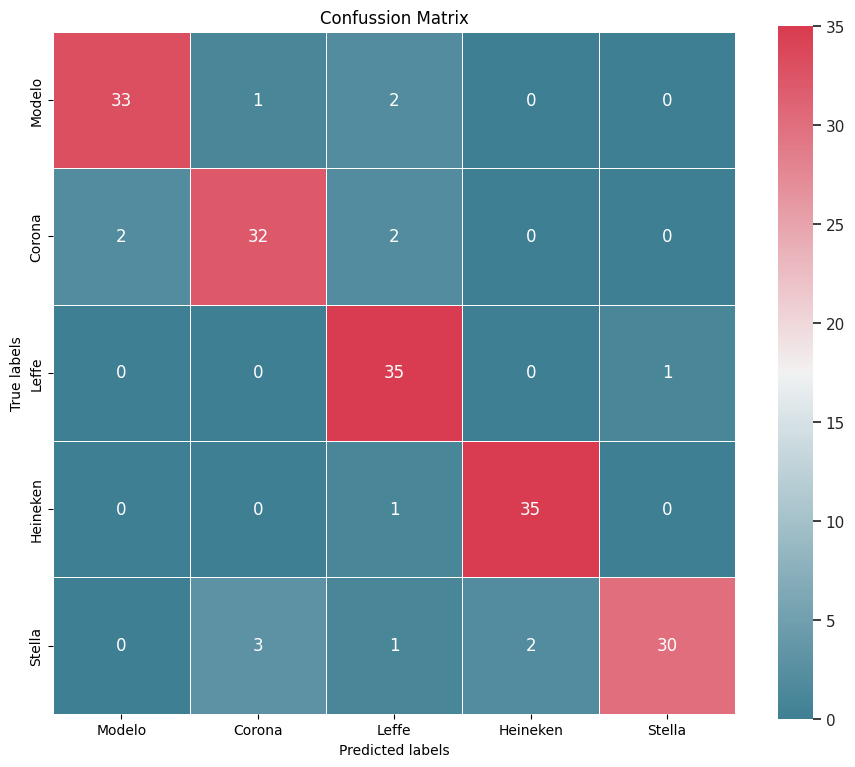

In [ ]:
C = confusion_matrix(test_true_labels, test_predicted_labels)

f, ax = plt.subplots(figsize=(11, 9))
sns.set()
cmap = sns.diverging_palette(220, 8, as_cmap=True)
ax = sns.heatmap(C, cmap=cmap, square=True,
                 annot=True, fmt='d', linewidths=.5)
ax.set_title('Confussion Matrix')
ax.set_xticklabels(LABEL_NAMES)
ax.set_yticklabels(LABEL_NAMES)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

## Visalize Right Predictions (GRAD-CAM)

In [ ]:
# Code from: https://keras.io/examples/vision/grad_cam

def grad_cam(img):

  # Convert the image to array of type float32
  img = np.asarray(img, dtype = np.float32)

  # Reshape the image
  img = img.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
  img_scaled = img / 255

  # Name of the average pooling layer and dense final (you can see these names in the model summary)
  classification_layers = ["dense_1","softmax"]

  # Last convolutional layer in the model
  final_conv = model.get_layer("block5_pool")

  # Create a model with original model inputs and the last conv_layer as the output
  final_conv_model = keras.Model(model.inputs, final_conv.output)

  # Then we create the input for classification layer, which is the output of last conv layer
  classification_input = keras.Input(shape = final_conv.output.shape[1:])

  # We iterate through the classification layers, to get the final layer and then append 
  # the layer as the output layer to the classification model.
  temp = classification_input
  for layer in classification_layers:
      temp = model.get_layer(layer)(temp)
  classification_model = keras.Model(classification_input, temp)


  # We use gradient tape to monitor the 'final_conv_output' to retrive the gradients
  # corresponding to the predicted class
  with tf.GradientTape() as tape:
      # Pass the image through the base model and get the feature map 
      final_conv_output = final_conv_model(img_scaled)

      # Assign gradient tape to monitor the conv_output
      tape.watch(final_conv_output)
      
      # Pass the feature map through the classification model and use argmax to get the 
      # index of the predicted class and then use the index to get the value produced by final
      # layer for that class
      prediction = classification_model(final_conv_output)
      predicted_class = tf.argmax(prediction[0][0][0])
      predicted_class_value = prediction[:,:,:,predicted_class]
  
  # Get the gradient corresponding to the predicted class based on feature map.
  gradient = tape.gradient(predicted_class_value, final_conv_output)

  # Reduce the other dimensions, 
  gradient_channels = tf.reduce_mean(gradient, axis=(0, 1, 2))

  # We then convert the feature map produced by last conv layer
  final_conv_output = final_conv_output.numpy()[0]

  gradient_channels = gradient_channels.numpy()

  # We multiply the filters in the feature map produced by final conv layer by the 
  # filter values that are used to get the predicted class. By doing this we inrease the
  # value of areas that helped in making the prediction and lower the value of areas, that 
  # did not contribute towards the final prediction
  for i in range(gradient_channels.shape[-1]):
      final_conv_output[:, :, i] *= gradient_channels[i]

  # We take the mean accross the channels to get the feature map
  heatmap = np.mean(final_conv_output, axis=-1)

  # Normalizing the heat map between 0 and 1, to visualize it
  heatmap_normalized = np.maximum(heatmap, 0) / np.max(heatmap)

  # Rescaling and converting the type to int
  heatmap = np.uint8(255 * heatmap_normalized )

  # Create the colormap
  color_map = plt.cm.get_cmap('viridis')

  # get only the rb features from the heatmap
  color_map = color_map(np.arange(256))[:, :3]
  heatmap = color_map[heatmap]

  # convert the array to image, resize the image and then convert to array
  heatmap = keras.preprocessing.image.array_to_img(heatmap)
  heatmap = heatmap.resize((IMG_SIZE, IMG_SIZE))
  heatmap = np.asarray(heatmap, dtype = np.float32)

  # Add the heatmap on top of the original image
  final_img = heatmap * 1.0 + img[0]
  final_img = keras.preprocessing.image.array_to_img(final_img)

  return final_img, heatmap_normalized

In [ ]:
# to get right and wrong sets
testing_labels = [LABEL_NAMES[x] for x in test_true_labels]
prediction = [LABEL_NAMES[x] for x in test_predicted_labels]

rigth_list = [testing_labels[i] == prediction[i] for i in range(len(prediction))]
right_idx = [i for i, x in enumerate(rigth_list) if x]
wrong_idx = [i for i, x in enumerate(rigth_list) if not x]
idx_list = [i for i, x in enumerate(rigth_list)]

<ipython-input-8-a1b4cf2e22d9>:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis')


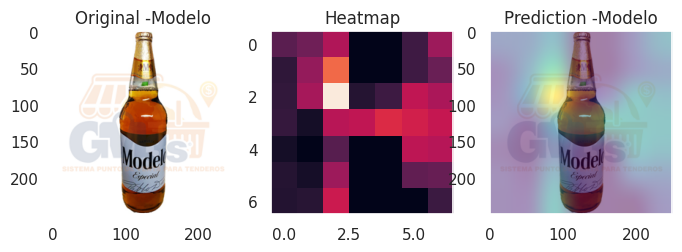

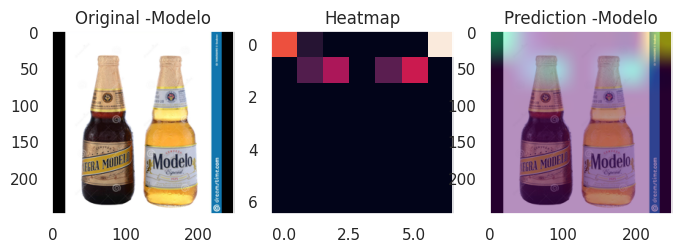

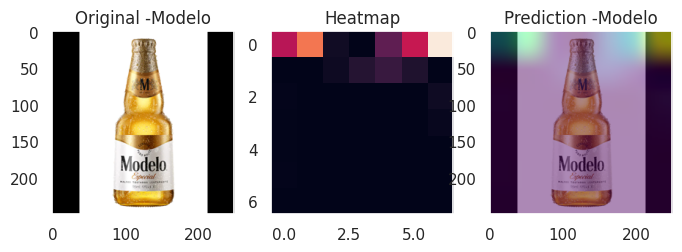

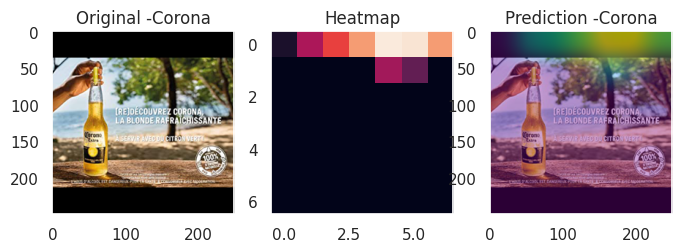

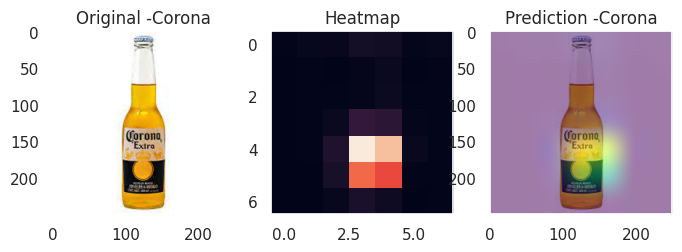

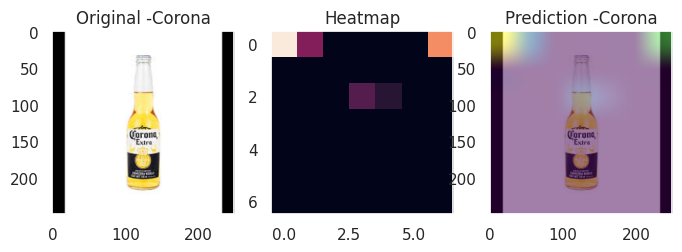

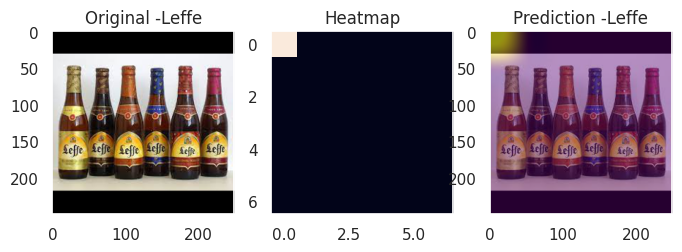

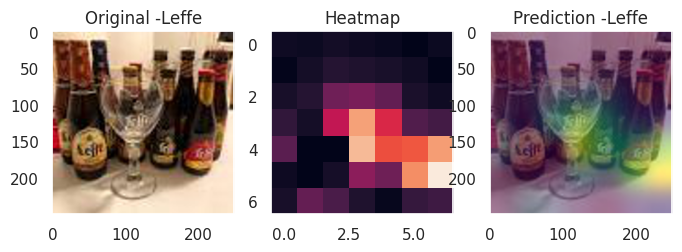

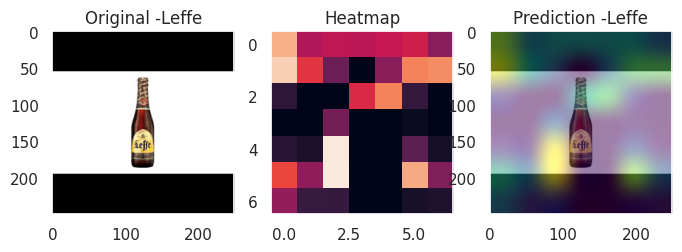

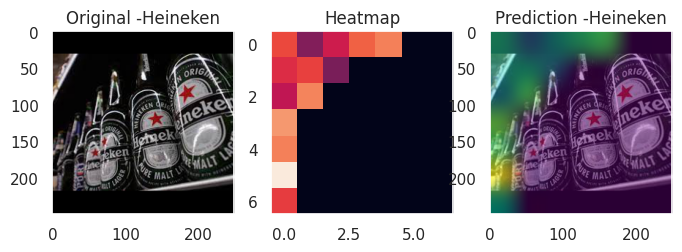

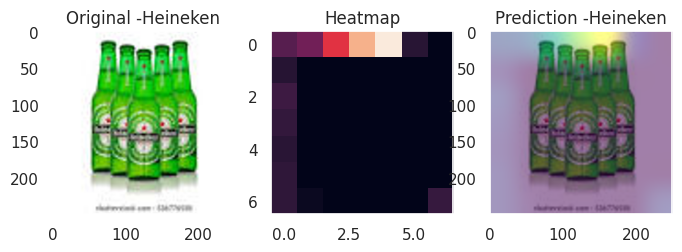

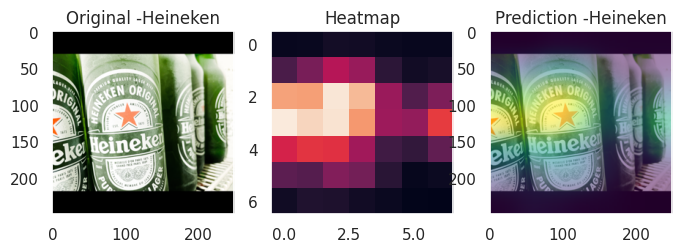

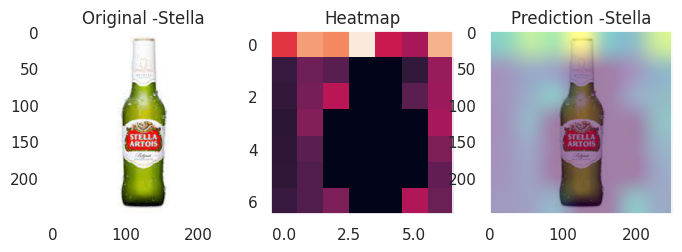

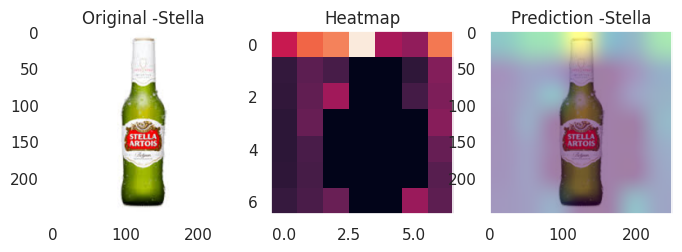

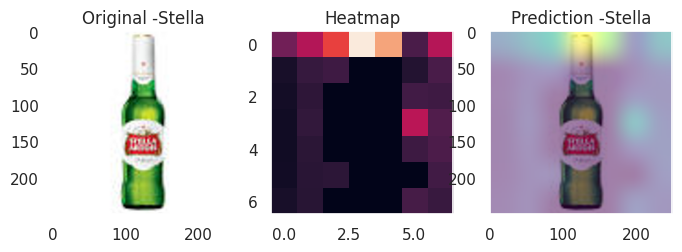

In [ ]:
#Visualize the images in the dataset

for idx in range(5):
  for x in range(3):
    try:
      i=random.choice(list(set(find_indices(test_labels_2, LABEL_NAMES[idx])).intersection(right_idx)))
    except:
      i=random.choice(list(compress(idx_list,rigth_list)))
    plt.figure(figsize = (8,8))
    plt.subplot(131)
    #i = random.randint(0, len(image))
    gradcam, heatmap = grad_cam(images[i])
    plt.title("Original -" + test_labels_2[i])
    plt.imshow(images[i])
    plt.grid(False)

    plt.subplot(132)
    plt.title("Heatmap") 
    plt.imshow(heatmap)
    plt.grid(False)
    
    plt.subplot(133)
    plt.title("Prediction -" + prediction[i]) 
    plt.imshow(gradcam)  
    plt.grid(False)

    plt.show()

## Visualize Wrong Predictions (GRAD-CAM)

<ipython-input-8-a1b4cf2e22d9>:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis')


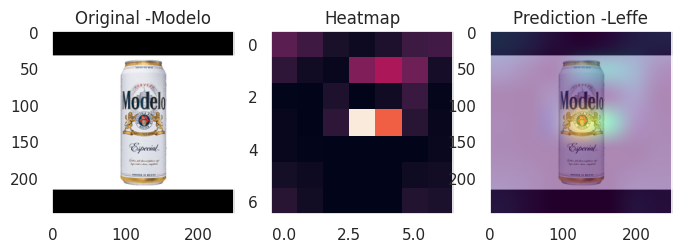

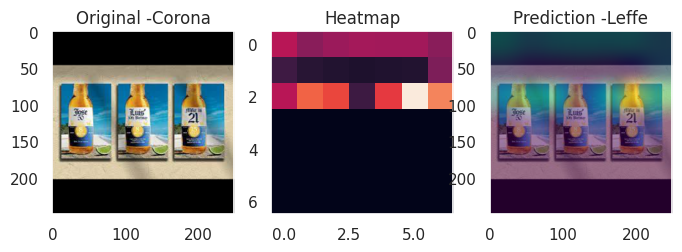

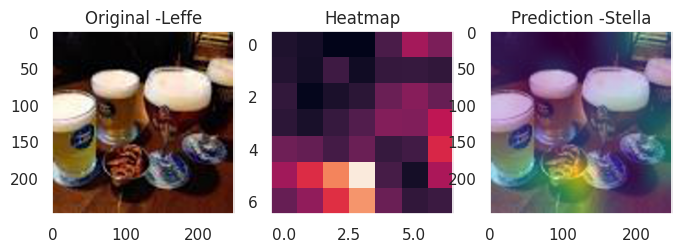

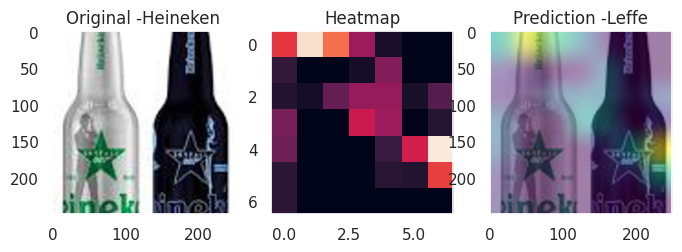

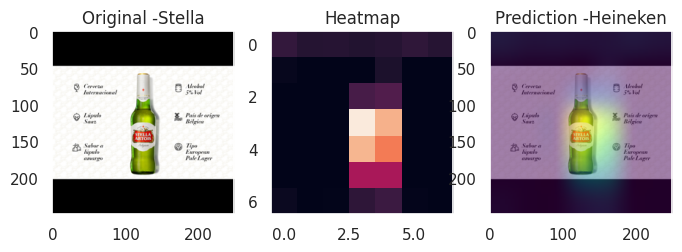

In [ ]:
for idx in range(5):
  try:
    i=random.choice(list(set(find_indices(test_labels_2, LABEL_NAMES[idx])).intersection(wrong_idx)))
  except:
    i=random.choice(list(compress(idx_list,list(~np.array(rigth_list)))))

  #print(i)
  #wait = input("Press enter to continue")
  plt.figure(figsize = (8,8))
  plt.subplot(131)
  gradcam, heatmap = grad_cam(images[i])
  plt.title("Original -" + test_labels_2[i])
  plt.imshow(images[i])
  plt.grid(False)

  plt.subplot(132)
  plt.title("Heatmap") 
  plt.imshow(heatmap)
  plt.grid(False)
  
  plt.subplot(133)
  plt.title("Prediction -" + prediction[i]) 
  plt.imshow(gradcam)  
  plt.grid(False)

  plt.show()